In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, num_workers=2)

test_data = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, num_workers=2)

# plane, car, bird, cat, deer, dog, frog, horse, ship, truck

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


0 torch.Size([128, 3, 32, 32]) torch.Size([128])


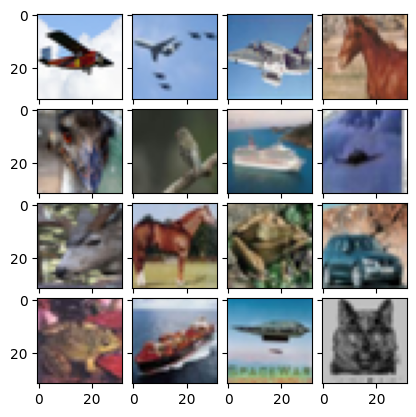

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# get batch from dataloader
sampler = enumerate(train_dataloader)
batch_idx, (x, y) = next(sampler)
print(batch_idx, x.shape, y.shape)

# select sample images
images = [x[i].squeeze().permute(1, 2, 0).numpy()/2 + 0.5 for i in range(16)]

# create and display plot
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image)

plt.show()

In [10]:
import torch.nn as nn

# create model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        # 2D conv weight [3, 3, 3] x 16
        # torch.Size([128, 3, 32, 32])
        self.conv_l = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1)

        self.act = nn.ReLU(inplace=True)  # activation function
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.linear = nn.Linear(in_features=256, out_features=10)

    def forward(self, x_input):  # [B, 3, 32, 32] = [B, C, H, W]
        # layer 1
        x1 = self.conv_0(x_input)  # [B, 16, 32, 32]
        x1 = self.pool(x1) # [B, 16, H/2, W/2]
        x1 = self.act(x1) # [B, 16, H/2, W/2]

        # layer 2
        x2 = self.conv_l(x1) # [B, 32, H/2, W/2]
        x2 = self.pool(x2) # [B, 32, H/4, W/4]
        x2 = self.act(x2) # [B, 32, H/4, W/4]

        # layer 3
        x3 = self.conv_2(x2) # [B, 64, H/4, W/4]
        x3 = self.pool(x3) # [B, 64, H/8, W/8]
        x3 = self.act(x3) # [B, 64, H/8, W/8]

        # layer 4
        x4 = self.conv_3(x3) # [B, 128, H/8, W/8]
        x4 = self.pool(x4) # [B, 128, H/16, W/16]
        x4 = self.act(x4) # [B, 128, H/16, W/16]

        # layer 5
        x5 = self.conv_4(x4) # [B, 256, H/16, W/16]
        x5 = self.pool(x5) # [B, 256, H/32, W/32]
        x5 = self.act(x5).flatten(1) # [B, 256, H/32, W/32]

        return self.linear(x5)




In [11]:
# define the training and test steps
def train(model, ce_loss, optimizer, dataloader):
  model.train()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()

    pred = model(x)
    loss = ce_loss(pred, y)
    loss.backward()
    optimizer.step()

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

def test(model, ce_loss, dataloader):
  model.eval()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')

    pred = model(x)
    loss = ce_loss(pred, y)

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

In [12]:
import torch.optim as optim

# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNN().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

[0] Train loss: 2.14, Train Accuracy: 0.20, Test loss: 1.81, Test Accuracy: 0.33
[1] Train loss: 1.61, Train Accuracy: 0.41, Test loss: 1.41, Test Accuracy: 0.48
[2] Train loss: 1.36, Train Accuracy: 0.51, Test loss: 1.29, Test Accuracy: 0.53
[3] Train loss: 1.19, Train Accuracy: 0.57, Test loss: 1.17, Test Accuracy: 0.58
[4] Train loss: 1.05, Train Accuracy: 0.62, Test loss: 1.02, Test Accuracy: 0.64
[5] Train loss: 0.94, Train Accuracy: 0.67, Test loss: 0.93, Test Accuracy: 0.67
[6] Train loss: 0.84, Train Accuracy: 0.71, Test loss: 0.90, Test Accuracy: 0.68
[7] Train loss: 0.76, Train Accuracy: 0.73, Test loss: 0.87, Test Accuracy: 0.70
[8] Train loss: 0.67, Train Accuracy: 0.76, Test loss: 0.82, Test Accuracy: 0.72
[9] Train loss: 0.61, Train Accuracy: 0.79, Test loss: 0.79, Test Accuracy: 0.72
[10] Train loss: 0.55, Train Accuracy: 0.80, Test loss: 0.83, Test Accuracy: 0.72
[11] Train loss: 0.49, Train Accuracy: 0.83, Test loss: 0.84, Test Accuracy: 0.72
[12] Train loss: 0.45, Tra

In [ ]:
import torch.nn as nn

# create model
class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x

In [ ]:
# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNNBatchNorm().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

In [ ]:
import torch.nn as nn

# create model
class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x

In [ ]:
# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNNDropout().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

In [ ]:
# Do data augmentation for homework...